In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf
from scipy.stats import bartlett, levene, jarque_bera, normaltest
from statsmodels.tsa.stattools import acf
from sqlalchemy import create_engine

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

In [26]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

weather_df = pd.read_sql_query('select * from weatherinszeged', con=engine)

engine.dispose()

In [27]:
print(len(weather_df))
weather_df.head()

96453


,date,summary,preciptype,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure,dailysummary
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [28]:
#removing rows where the pressure is = 0 as this is likely 
#representative of no sample collection
no_pressure = weather_df.loc[weather_df['pressure'] == 0]

weather_df.drop(no_pressure.index, inplace=True)
len(weather_df)

95165

In [63]:
#removing rows that have 0 humidity as this is physically impossible
#outside of a laboratory environment
no_humidity = weather_df.loc[weather_df['humidity'] == 0]

weather_df.drop(no_humidity.index, inplace=True)
len(weather_df)

95143

In [64]:
Y = weather_df['temperature']
X = weather_df[[
    'humidity', 
    'windspeed', 
    'windbearing', 
    'pressure'
]]

lrm = linear_model.LinearRegression()
lrm.fit(X,Y)

print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: ', lrm.intercept_)
print('\nR^2: ', lrm.score(X,Y))


Coefficients: 
 [-3.29588836e+01 -3.18926097e-01  2.47829801e-03 -4.15538916e-01]

Intercept:  461.6840726659266

R^2:  0.5331061058294908


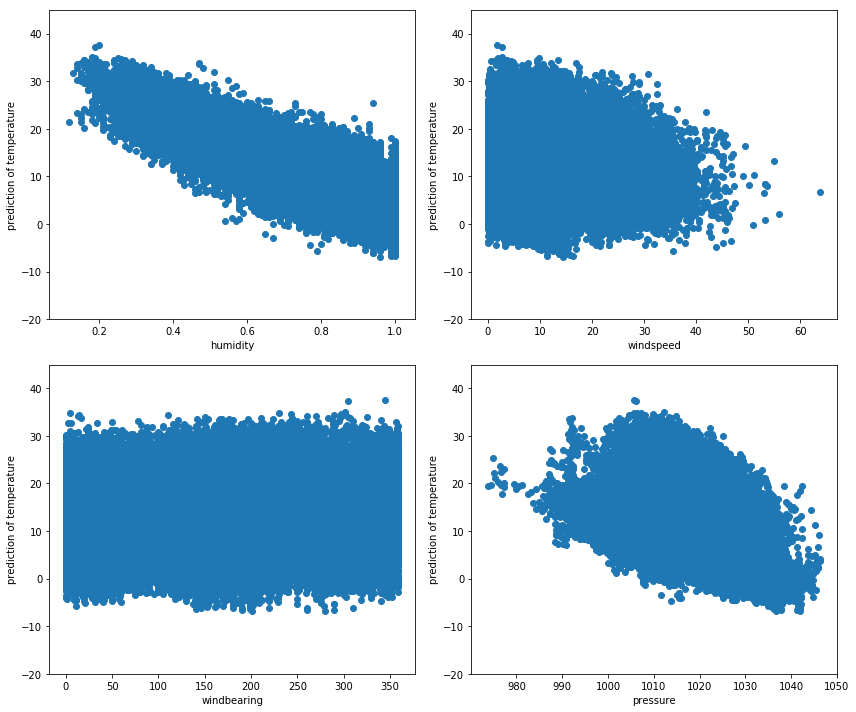

In [65]:
predictions = lrm.predict(X)
plt.figure(figsize=(12,10))
n=0
for col in X.columns:
    n +=1
    plt.subplot(2,2,n)
    plt.scatter(X[col], predictions)
    plt.ylim(-20, 45)
    plt.xlabel(col)
    plt.ylabel('prediction of temperature')
plt.tight_layout()
plt.show()

#### Assumption 1: linearity of the model in its coefficients

Windspeed and the windbearing have basically no correlation to the predicted temperature. Pressure and humidity are closer to being correlated to temperature, but the correlations are not perfect. This is evidence that there might be some underlying issues with the model coefficients.

Confirming the mean error of the model is zero.
Mean of the errors in the model is: 4.445008919318634e-15

Running Barlett and Levene tests to check for homoscedasticity and comparing the predictions to the residuals to check for consistent distributions.
Bartlett test statistic is 418.023 and p-value is 6.57388e-93
Levene test statistic is 290.982 and p-value is 3.39769e-65


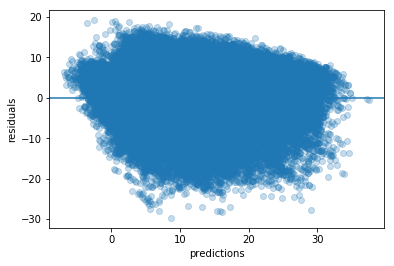

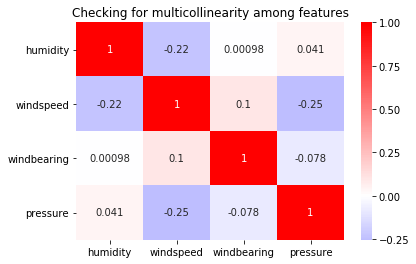

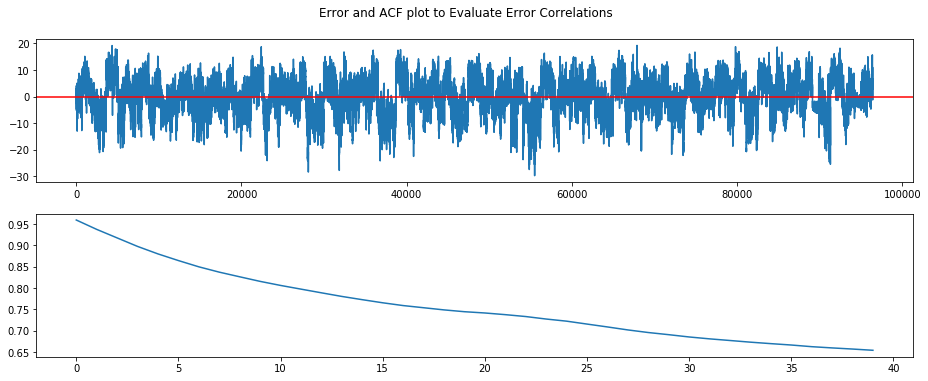

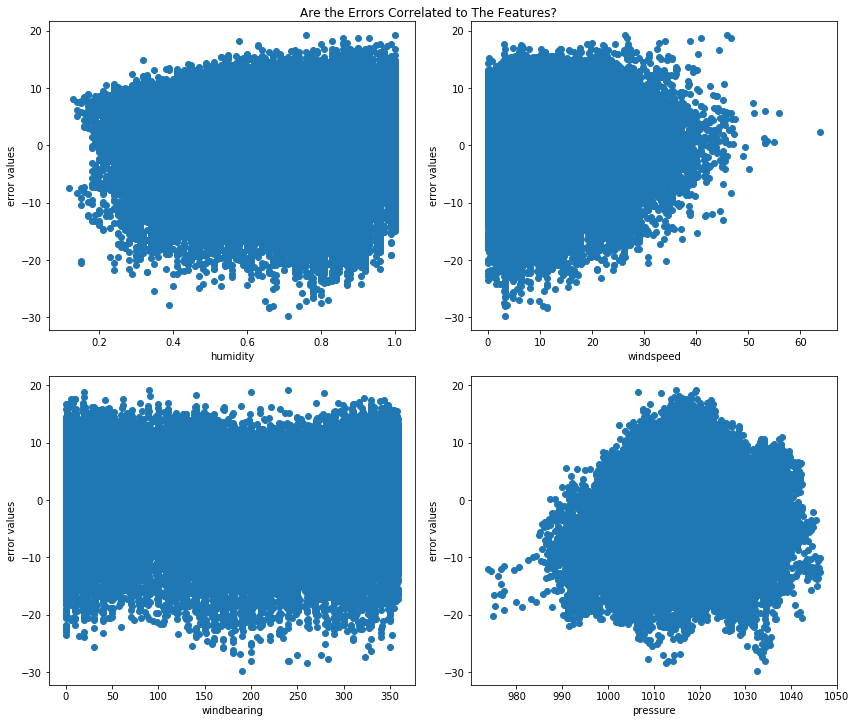

In [98]:
#assumption 2: error term should be zero on average
errors = Y - predictions
print('Confirming the mean error of the model is zero.')
print('Mean of the errors in the model is: {}\n'.format(np.mean(errors)))

#assumption 3: homoscedasticity
bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)
print('Running Barlett and Levene tests to check for homoscedasticity and comparing the predictions to the residuals to check for consistent distributions.')
print('Bartlett test statistic is {:3g} and p-value is {:3g}'.format(bart_stats[0], bart_stats[1]))
print('Levene test statistic is {:3g} and p-value is {:3g}'.format(lev_stats[0], lev_stats[1]))

plt.scatter(predictions, errors, alpha=0.25)
plt.xlabel('predictions')
plt.ylabel('residuals')
plt.axhline(0)
plt.show()

#assumption 4: low multicolllinearity
sns.heatmap(X.corr(), annot=True, cmap='bwr', center=0)
plt.title('Checking for multicollinearity among features')
plt.show

print('\n')
#assumption 5: error terms are uncorrelated to one another
acf_data = acf(errors)

plt.figure(figsize=(13,5))
plt.suptitle('Error and ACF plot to Evaluate Error Correlations', y=1.05, fontsize=12)

plt.subplot(2,1,1)
plt.plot(errors)
plt.axhline(y=0, color='red')

plt.subplot(2,1,2)
plt.plot(acf_data[1:])
plt.tight_layout()
plt.show()

print('\n')
#assumption 6: features should not be correlated with the errors
plt.figure(figsize=(12,10))

n=0
for col in X.columns:
    n +=1
    plt.subplot(2,2,n)
    plt.scatter(X[col], errors)
    plt.xlabel(col)
    plt.ylabel('error values')
plt.suptitle('Are the Errors Correlated to The Features?', y=1.0)
plt.tight_layout()
plt.show()

The assumption that the mean error is equal to zero holds true for this model. The sklearn LinearRegression model uses a constant which will force the mean error to be zero.

Based on the p-values for the Bartlett and Levene tests being < 0.05 we can reject the null hypothesis that the errors are homoscedastic. The plot of residuals vs. predictions also shows us that there is a non-consistent distribution of error in the model. It's possible that there are more outliers in the data that we haven't already removed, but considering there are only 4 features in the model that are only weakly correlated to the target variable it is more likely that we need more relevant variables to fix the heteroscedastic issue.

The heatmap of the features correlation matrix does a good job of showing low multicollinearity in the model. Windspeed has a very weak correlation (~0.2) with humidity and pressure, but i feel like that is too weak to be causing any issues in the model.

The Autocorrelation plot of the model errors show all 40 observations above 0.65 and the first ~10 observation are above 0.8. This shows that there are a lot of issues with errors correlating to one another in the model. Again this is likely due to an under-featured model that is missing important features to predict temperature.

The last group of scatter plots show no trends between the error values and the features. This means that the last assumption is held true.

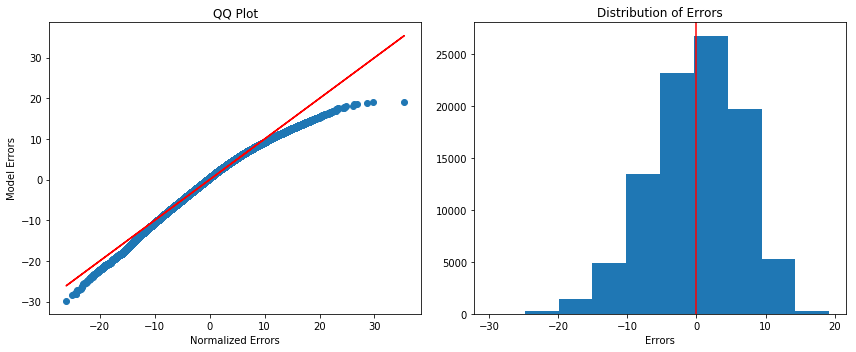

Jarque-Bera test statistic is 2317.8020163325123 and p-value is 0.0
Normality test statistic is 2167.935051764822 and p-value is 0.0


In [101]:
#The last thing to check for is whether or not the errors in the model are normally distributed
normal_error = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(normal_error), np.sort(errors))
plt.plot(normal_error, normal_error, color='red')
plt.xlabel('Normalized Errors')
plt.ylabel('Model Errors')
plt.title('QQ Plot')

plt.subplot(1,2,2)
plt.hist(errors)
plt.axvline(x=0, color='red')
plt.xlabel('Errors')
plt.title('Distribution of Errors')

plt.tight_layout()
plt.show()

jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)
print('Jarque-Bera test statistic is {} and p-value is {}'.format(jb_stats[0], jb_stats[1]))
print('Normality test statistic is {} and p-value is {}'.format(norm_stats[0], norm_stats[1]))

Both p-values are < 0.05 using the Jarque-Bera and Normality statistical tests for normality. Because they are less than 0.05 we will reject the null hypothesis that the errors are normally distributed. 

The QQ plot shows divergence from the perfectly normal line at ~11 on the x-axis and continues to dip below the line. This matches well with the histogram to the right that shows the errors to be left skewed.